# ETRI Multiview DASH QoE Calculator
## T1 : Calculating Average Video Rates for each viewpoints and quality levels
* 목적 : QoE 계산을 위해 Multi-View Video의 평균 품질 정보 계산
* Output - Average Video Rate 값을 가지는 DataFrame 
    - Index --> Video Quality Level
    - Columns --> View Points 
* Input 
    - multiviewvideo.csv 경로 정보 : Simulation에 쓰이는 다중 시점 비디오 정보 파일의 경로
* 동작 개요
    - multiviewvideo.csv의 첫 줄을 읽어 viewpoint의 수, segment의 수와 길이 등의 메타 정보 해석
    - 이후 [video_quality, viewpoint] 조합 별로 Segment 길이 값을 읽은 후 평균 Video Rate를 계산한다.
* 사용법
    - 아래 Code Cell을 실행
    - 결과는 각 viewpoint 별 평균 Video Rate가 Mbps 단위로 표시되는 DataFrame Head가 표출

In [15]:
import numpy as np
import pandas as pd

f = open('../source/ns-3.34/contrib/etri_mvdash/multiviewvideo.csv')
mvinfo = [int(x) for x in f.readline().split()] 
f.close()

nViewpoints = mvinfo[0]
nSegments = mvinfo[1]
segDuration = mvinfo[2]
nRates = mvinfo[3]
# mvinfo[3] : # of rates/quality levels in the 1st viewpoint
#nstreams = sum(mvinfo[3:(mvinfo[0]+3)])

df = pd.read_csv('../source/ns-3.34/contrib/etri_mvdash/multiviewvideo.csv',sep="\t", header=None, skiprows=1)
df_rate_kbps = pd.DataFrame(df.mean().values.reshape((nViewpoints,nRates)).transpose()*8/segDuration, 
                   columns=["viewpoint_"+str(i+1) for i in range(nViewpoints)])
df_rate_kbps.head()

,viewpoint_1,viewpoint_2,viewpoint_3,viewpoint_4,viewpoint_5
0,0.176392,0.176643,0.176504,0.176356,0.176393
1,0.347921,0.348043,0.347769,0.348058,0.347989
2,0.901745,0.902152,0.901960,0.902652,0.899600
3,1.875856,1.876975,1.875812,1.875432,1.875122
4,3.938739,3.938752,3.935874,3.947304,3.941852


## T2: Calculating Q points for each viewpoints and quality levels
* 목적 : QoE 계산을 위해 Q Score를 계산
* Output - Q Score를 가지는 DataFrame 
    - Index --> Video Quality Level
    - Columns --> View Points 
* Input 
    - df_rate_kbps : 위 Code Cell의 결과
* 동작 개요
    - 최저 품질 (video_quality level = 0)을 기준으로 Q score 계산
    - 최저 품질의 Q score = 1
* 사용법
    - 아래 Code Cell을 실행
    - viewpoint와 video_quality_level에 대해 구해진 Q Score Matrix 표출

In [16]:
Rmin_vp = df_rate_kbps.iloc[0].values

Rn_vp = np.ones(nViewpoints)

for vp in range(1,8) :
    #n_vp.append(np.log2(df_rate_kbps.iloc[vp].values / Rmin_vp)+1, axis=0)
    #np.append(Rn_vp,np.log2(df_rate_kbps.iloc[vp].values / Rmin_vp)+1, axis=0)
    Rn_vp = np.vstack((Rn_vp, np.log2(df_rate_kbps.iloc[vp].values / Rmin_vp)+1) )

df_qscore = pd.DataFrame(Rn_vp, columns=df_rate_kbps.columns)
#df_qscore.to_csv("qscore.csv")
print(df_qscore)

   viewpoint_1  viewpoint_2  viewpoint_3  viewpoint_4  viewpoint_5
0     1.000000     1.000000     1.000000     1.000000     1.000000
1     1.979972     1.978424     1.978430     1.980838     1.980250
2     3.353933     3.352531     3.353364     3.355680     3.350493
3     4.410691     4.409497     4.409743     4.410660     4.410122
4     5.480875     5.478827     5.478912     5.484305     5.482011
5     6.422447     6.421530     6.423529     6.424772     6.421721
6     7.701736     7.701333     7.701070     7.702418     7.700329
7     8.860774     8.857494     8.857437     8.860308     8.859840


## T3: Plot Multi-View Video Playback and Calculate QoE
* 목적 : Simulation에서 얻어진 다중 시점 비디오 재생 상황을 Viewpoint 변화를 중심으로 표현하고 QoE를 계산
* Output1 - Multi-View Video Play Plot 
    - X 축 - Segment Index / Time
    - Y 축 - View Points
    - Red Line - Segment Play 시점에서 선택된 현재 Viewpoint
    - Blue Line - Segment Request 시점에서 선택된 최대 품질의 Viewpoint
* Output2 - QoE  
    - 각 Viewpoint 별 QoE와 이들의 합인 Multi-View Video QoE
* Input 
    - csv_path : Simulation 출력 파일이 존재하는 파일의 경로
    - simId : Simulation Id
    - clientId : Client Id
    - c_alpha, c_mu, c_lambda : QoE 계산에 쓰이는 계수(Coefficients) 값
    
* 동작 개요 
    - read_playbacklog
        +Input 정보를 바탕으로 Simulation 결과 파일을 df_play DataFrame으로 읽어 들임
    - show_multiview_play   
        + 각 segment 시점 마다 재생 기준 현재 viewpoint, 
        + Request 기준 최고 품질 viewpoint 를 구하고
        + 각각 plt.plot()을 이용하여 그래프 출력
    - QoE
        + 지정한 viewpoint (vp)에 대해 QoE 값을 계산
* 사용법
    - T1, T2 Cell을 먼저 실행하여야 한다
    - simId, clientId 를 적절하게 설정한다
        + QoE Coefficients도 필요하면 변경한다.
    - 아래 Code Cell을 실행

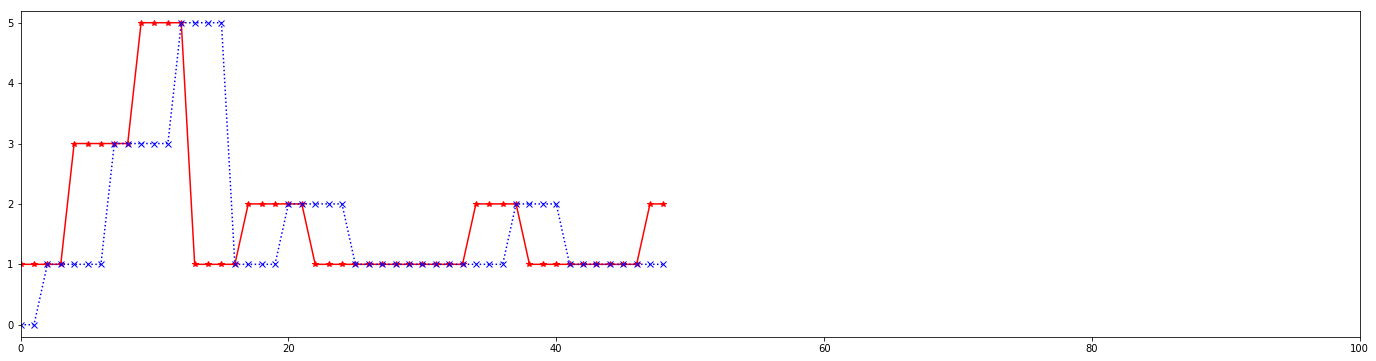

[0] QoE Total =  89.719, Part1 = 114.307, Part 2 =   0.000, Part 3 =  24.588
[1] QoE Total =  16.580, Part1 =  29.809, Part 2 =   0.000, Part 3 =  13.229
[2] QoE Total =  13.830, Part1 =  20.646, Part 2 =   0.000, Part 3 =   6.816
[3] QoE Total =   4.900, Part1 =   4.900, Part 2 =   0.000, Part 3 =   0.000
[4] QoE Total =   9.490, Part1 =  14.609, Part 2 =   0.000, Part 3 =   5.118
Multi-View Video QoE 134.519


In [22]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

def read_playbacklog(csv_path, simId, clientId) :
    playfilename = csv_path + "playback_sim" + str(simId) +"_cl" + str(clientId) + ".csv"
    return pd.read_csv(playfilename, sep="\t")

def show_multiview_play(df_play) :
    nSegments = df_play.shape[0]
    #print(df_play.head())
    vp_high = ((df_play.iloc[:,3:] > 0)* [1,2,3,4,5]).T.sum().astype(int)

    plt.figure(figsize=(24, 6))
    plt.plot(df_play.tIndex, df_play.vpoint+1, 'r*-', df_play.tIndex, vp_high, 'bx:')
    plt.axis([0,100,-0.2,5.2])
    plt.show()
    return

def q(viewpoint, rIndex) :
    return df_qscore.iloc[rIndex, viewpoint-1]

def QoE(df_play, vp, c_alpha, c_mu, c_lambda) :
    Vn_list = df_play.vpoint.values
    Rn_list = df_play.iloc[:,3+vp].values
    Tn_list = (np.diff(df_play.Start) - segDuration)/segDuration
    
    qscores = np.zeros(Rn_list.size)
    for i in range(Rn_list.size) :
        qscores[i] = q (vp+1, Rn_list[i])
    qoe_part1 = sum((Vn_list == vp) * qscores) + c_alpha * sum((Vn_list != vp) * qscores)
    qoe_part2 = sum((df_play.vpoint == vp)[1:] * Tn_list) \
                + c_alpha * sum((df_play.vpoint != vp)[1:] * Tn_list)    
    qoe_part3 = sum((df_play.vpoint == vp)[1:] * abs(np.diff(qscores))) \
                + c_alpha * sum((df_play.vpoint != vp)[1:] * abs(np.diff(qscores)))    
    q_total = qoe_part1 - c_mu * qoe_part2 - c_lambda * qoe_part3
    outstr = "[{}] QoE Total = {:>7.3f}, Part1 = {:>7.3f}, Part 2 = {:>7.3f}, Part 3 = {:>7.3f}".format(vp, \
                q_total, qoe_part1, qoe_part2, qoe_part3)
    print (outstr)
    return q_total


# ==================================================
csv_path = '../source/ns-3.34/contrib/etri_mvdash/'
simId = 0
clientId = 0

c_alpha = 0.1
c_mu = 2.66
c_lambda = 1.0


df_play = read_playbacklog(csv_path, simId, clientId)
show_multiview_play(df_play)

multi_qoe = 0
for vp in range(nViewpoints) :
    multi_qoe += QoE(df_play, vp, c_alpha, c_mu, c_lambda)     
print("Multi-View Video QoE {:>7.3f}".format(multi_qoe))